In [ ]:
import pandas as pd
import numpy as np
import pyreadr
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from typing import List, Optional, Sequence, Tuple, Union, Dict
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

from sklearn.manifold import TSNE, MDS
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.metrics import classification_report, confusion_matrix, f1_score

import keras_tuner as kt
from dataclasses import dataclass, asdict
import random
from datetime import datetime
import joblib
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import os, json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize
from statsmodels.stats.contingency_tables import Table2x2


from tensorflow.keras.models import load_model



We load the expression, gene and sample data we saved after the pre-processing we applied in R. We aim to predict tumor grade from the RNAseq data, so we examine potential class imbalance in the tumor grade sample metadata column, and we remove NA values in tumors with unidentified grade.

In [2]:
#load expression, genes and samples data
expression=pd.read_csv("C:/Users/joann/Desktop/M2/Deep_Learning/merged_expression.csv",index_col=0)
genes=pd.read_csv("C:/Users/joann/Desktop/M2/Deep_Learning/merged_genes.csv")
samples = pyreadr.read_r("C:/Users/joann/Desktop/M2/Deep_Learning/merged_samples.rds")
samples = samples[None]

In [3]:
#check what the expression, genes and samples data look like
print(expression.columns[:5])
print(expression.head(2))
print(samples.head(2))

Index(['ENSG00000276168.1', 'ENSG00000129824.16', 'ENSG00000133048.13',
       'ENSG00000012223.13', 'ENSG00000198695.2'],
      dtype='object')
                              ENSG00000276168.1  ENSG00000129824.16  \
TCGA-HT-7468-01A-11R-2027-07           8.423027           13.253145   
TCGA-DU-7015-01A-11R-2027-07           8.252623            5.532866   

                              ENSG00000133048.13  ENSG00000012223.13  \
TCGA-HT-7468-01A-11R-2027-07            7.491808            4.879747   
TCGA-DU-7015-01A-11R-2027-07            8.707316            5.087127   

                              ENSG00000198695.2  ENSG00000228253.1  \
TCGA-HT-7468-01A-11R-2027-07          15.950897          12.763416   
TCGA-DU-7015-01A-11R-2027-07          16.922914          13.431528   

                              ENSG00000198763.3  ENSG00000133110.15  \
TCGA-HT-7468-01A-11R-2027-07          17.025877            5.074539   
TCGA-DU-7015-01A-11R-2027-07          17.670450            4.085189   


In [4]:
#explore the samples metadata
print(samples.shape)
# list of column names
samples.columns.tolist()

#check for potential class imbalance in tumor grade
print(samples["tumor_grade"].value_counts())

#count how many NA values are in the tumor grade column
print(samples["tumor_grade"].isna().sum())

(925, 114)
tumor_grade
G4    391
G3    216
G2    211
Name: count, dtype: int64
107


In [100]:
#we exclude samples with NA tumor grade
samples_all = samples.copy() #keep original samples dataframe
expression_all = expression.copy() #keep original expression dataframe

samples_sup = samples_all.dropna(subset=["tumor_grade"])
expression_sup = expression_all.loc[samples_sup.index]

assert expression_sup.shape[0] == samples_sup.shape[0], "Mismatch in number of samples between expression and samples dataframes after dropping NA tumor grades."



We configure the model and ensure reproducibility.

In [101]:
@dataclass
class Config:
    out_dir: str = "C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run"
    seed: int = 42

    # labels
    label_col: str = "tumor_grade"
    label_map: dict = None  # set in main if None

    # splits
    test_size: float = 0.15
    n_folds: int = 9  # 9-fold CV on train+val portion

    # training/tuning
    max_epochs: int = 100
    early_stop_patience: int = 5

    # tuner
    hyperband_factor: int = 3
    objective: str = "val_accuracy"

def set_global_seed(seed: int) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # makes TF ops more deterministic when possible
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

def make_run_dir(base_dir: str) -> str:
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_dir, ts)
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

We assign the classes. Grade II tumors will be 0, grade III will be 1 and grade IV will be 2.

In [102]:
def make_y(samples_sup: pd.DataFrame, label_col: str, label_map: dict) -> np.ndarray:
    """
    Convert tumor grade strings to integer classes.
    Example mapping: {"G2":0, "G3":1, "G4":2}
    """
    y = samples_sup[label_col].astype(str).map(label_map)
    if y.isna().any():
        bad = samples_sup.loc[y.isna(), label_col].unique()
        raise ValueError(f"Found unmapped labels: {bad}")
    return y.astype(int).to_numpy()


We construct our  splits: we will have a hold-out test set, and run a 9-fold cross-validation on the rest of the data. In the cross-validation we include training and validation tests

In [104]:
def split_holdout_test(X: pd.DataFrame, y: np.ndarray, cfg: Config):
    """
    Hold out ONE stratified test set.
    Remaining data is used for 9-fold CV (train/val folds).
    """
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y,
        test_size=cfg.test_size,
        random_state=cfg.seed,
        stratify=y
    )
    return X_trainval, X_test, y_trainval, y_test

def save_test_ids(run_dir: str, X_test: pd.DataFrame) -> None:
    pd.Index(X_test.index).to_series().to_csv(os.path.join(run_dir, "test_ids.csv"), index=False)

def save_fold_ids(run_dir: str, fold: int, X_train: pd.DataFrame, X_val: pd.DataFrame) -> None:
    fold_dir = os.path.join(run_dir, f"fold_{fold:02d}")
    os.makedirs(fold_dir, exist_ok=True)
    pd.Index(X_train.index).to_series().to_csv(os.path.join(fold_dir, "train_ids.csv"), index=False)
    pd.Index(X_val.index).to_series().to_csv(os.path.join(fold_dir, "val_ids.csv"), index=False)

We standardize the data, fitting on test data only to avoid data leakage

In [105]:
def standardize_train_val(X_train: pd.DataFrame, X_val: pd.DataFrame):
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train).astype(np.float32)
    X_val_s = scaler.transform(X_val).astype(np.float32)
    return X_train_s, X_val_s, scaler

We build our multi-layer perceptron model (MLP) with ReLU activation function in the hidden layers and softmax in the output layer

In [110]:
def build_model(hp: kt.HyperParameters, input_dim: int, num_classes: int = 3) -> keras.Model:
    """
    MLP with tunable depth and two architecture modes:
      1) Free: each layer can have its own units (picked from a grid)
      2) Pyramid: pick a base width; each next layer is half the previous (e.g. 32 -> 16 -> 8)
    """

    # batch size is tuned by your HyperbandWithBatchSize tuner
    hp.Choice("batch_size", [16, 32, 64, 128])

    # --- depth ---
    n_layers = hp.Int("n_layers", 2, 6)

    # --- regularization / optimizer ---
    l2_strength = hp.Choice("l2", [0.0, 1e-5, 1e-4, 1e-3])
    lr = hp.Choice("lr", [1e-4, 3e-4, 1e-3, 3e-3])

    # --- dropout (global) ---
    dropout = hp.Float("dropout", 0.1, 0.6, step=0.1)

    # --- units search space ---
    units_grid = [8, 16, 32, 64, 128, 256]

    # --- architecture mode ---
    arch_mode = hp.Choice("arch_mode", ["free", "pyramid_half"])

    # Decide units per layer
    layer_units = []

    if arch_mode == "free":
        for i in range(n_layers):
            u = hp.Choice(f"units_l{i+1}", units_grid)
            layer_units.append(u)

    elif arch_mode == "pyramid_half":
        base_units = hp.Choice("base_units", units_grid)
        min_units = hp.Choice("min_units", [8, 16])

        u = base_units
        for i in range(n_layers):
            layer_units.append(max(u, min_units))
            u = u // 2

    # --- build network ---
    inputs = keras.Input(shape=(input_dim,), name="expression")
    x = inputs

    for i, u in enumerate(layer_units, start=1):
        x = layers.Dense(
            units=u,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength),
            name=f"dense_{i}",
        )(x)

        if dropout and dropout > 0:
            x = layers.Dropout(dropout, name=f"dropout_{i}")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="softmax")(x)

    model = keras.Model(inputs, outputs, name="MLP_grade")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


We tune the hyper-paramaters to choose the best model and avoid overfitting

In [111]:
class HyperbandWithBatchSize(kt.Hyperband):
    """Hyperband tuner that automatically uses hp['batch_size'] when fitting."""
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs["batch_size"] = hp.get("batch_size")
        return super().run_trial(trial, *args, **kwargs)

def tune_hyperparameters(X_train_s, y_train, X_val_s, y_val, input_dim: int, run_dir: str, cfg: Config):
    tuner_dir = os.path.join(run_dir, "tuner")
    os.makedirs(tuner_dir, exist_ok=True)

    tuner = HyperbandWithBatchSize(
        hypermodel=lambda hp: build_model(hp, input_dim=input_dim, num_classes=3),
        objective=kt.Objective(cfg.objective, direction="max"),
        max_epochs=cfg.max_epochs,
        factor=cfg.hyperband_factor,
        directory=tuner_dir,
        project_name="grade_mlp"
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=cfg.early_stop_patience,
        restore_best_weights=True
    )

    tuner.search(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=cfg.max_epochs,
        callbacks=[early_stop],
        verbose=1
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    return tuner, best_hp

We choose the best model to train on which we add weights to account for imbalanced classes

In [112]:
def make_class_weight(y_train: np.ndarray) -> dict:
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    return {int(c): float(w) for c, w in zip(classes, weights)}

def train_best(X_train_s, y_train, X_val_s, y_val, input_dim: int, best_hp, run_dir: str, cfg: Config):
    model = build_model(best_hp, input_dim=input_dim, num_classes=3)

    ckpt_path = os.path.join(run_dir, "best_model.keras")

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        patience=cfg.early_stop_patience,
        restore_best_weights=True
    )

    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        monitor="val_loss",
        save_best_only=True
    )

    # class weights (computed on this fold's training labels)
    class_weight = make_class_weight(y_train)
    print("Class weight:", class_weight)

    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=cfg.max_epochs,
        batch_size=best_hp.get("batch_size"),
        callbacks=[early_stop, checkpoint],
        verbose=1,
        class_weight=class_weight  # NEW
    )

    with open(os.path.join(run_dir, "history.json"), "w") as f:
        json.dump(history.history, f, indent=2)

    return model, ckpt_path

We evaluate the model

In [113]:
def evaluate(model: keras.Model, X_eval_s, y_eval, run_dir: str, prefix: str = "eval"):
    eval_loss, eval_acc = model.evaluate(X_eval_s, y_eval, verbose=0)

    probs = model.predict(X_eval_s, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    report = classification_report(y_eval, y_pred, output_dict=True)
    cm = confusion_matrix(y_eval, y_pred).tolist()
    macro_f1 = float(f1_score(y_eval, y_pred, average="macro"))

    results = {
        "loss": float(eval_loss),
        "accuracy": float(eval_acc),
        "macro_f1": macro_f1,
        "classification_report": report,
        "confusion_matrix": cm
    }

    with open(os.path.join(run_dir, f"{prefix}_metrics.json"), "w") as f:
        json.dump(results, f, indent=2)

    return results

We save all the run metadata

In [114]:
def save_run_metadata(run_dir: str, cfg: Config, best_hp, scaler):
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(asdict(cfg), f, indent=2)

    with open(os.path.join(run_dir, "best_hyperparameters.json"), "w") as f:
        json.dump(best_hp.values, f, indent=2)

    joblib.dump(scaler, os.path.join(run_dir, "scaler.joblib"))

    versions = {
        "python": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "tensorflow": tf.__version__,
        "keras_tuner": kt.__version__
    }
    with open(os.path.join(run_dir, "versions.json"), "w") as f:
        json.dump(versions, f, indent=2)

We plot Evaluation Plots 

In [115]:



def evaluate_and_save_plots(
    model,
    X_eval_s: np.ndarray,
    y_eval: np.ndarray,
    out_dir: str,
    class_names=("G2", "G3", "G4"),
    prefix: str = "test",
):
    os.makedirs(out_dir, exist_ok=True)
    n_classes = len(class_names)

    # predictions 
    eval_loss, eval_acc = model.evaluate(X_eval_s, y_eval, verbose=0)
    probs = model.predict(X_eval_s, verbose=0)          # (n, C)
    y_pred = np.argmax(probs, axis=1)

    # metrics 
    report = classification_report(y_eval, y_pred, output_dict=True)
    cm = confusion_matrix(y_eval, y_pred)
    macro_f1 = float(f1_score(y_eval, y_pred, average="macro"))

    results = {
        "loss": float(eval_loss),
        "accuracy": float(eval_acc),
        "macro_f1": macro_f1,
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
    }

    with open(os.path.join(out_dir, f"{prefix}_metrics.json"), "w") as f:
        json.dump(results, f, indent=2)

    
    # 1) Confusion matrix (raw)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(range(n_classes))
    ax.set_yticks(range(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix ({prefix})")
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{prefix}_confusion_matrix.png"), dpi=200)
    plt.close(fig)

    
    # 2) Confusion matrix (row-normalized)
    
    cm_norm = cm / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm)
    ax.set_xticks(range(n_classes))
    ax.set_yticks(range(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix Normalized ({prefix})")
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{prefix}_cm_normalized.png"), dpi=200)
    plt.close(fig)

    
    # 3) Per-class precision/recall/F1 bar plot
    
    rows = []
    for i, name in enumerate(class_names):
        d = report.get(str(i), None)
        if d is None:
            rows.append([name, np.nan, np.nan, np.nan])
        else:
            rows.append([name, d["precision"], d["recall"], d["f1-score"]])

    rows = np.array(rows, dtype=float, copy=False) if False else rows  # no-op; keeps notebook happy

    precision = [r[1] for r in rows]
    recall    = [r[2] for r in rows]
    f1s       = [r[3] for r in rows]

    fig, ax = plt.subplots()
    x = np.arange(n_classes)
    ax.bar(x - 0.2, precision, width=0.2, label="precision")
    ax.bar(x,       recall,    width=0.2, label="recall")
    ax.bar(x + 0.2, f1s,       width=0.2, label="f1")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1.0)
    ax.set_title(f"Per-class metrics ({prefix})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{prefix}_per_class_metrics.png"), dpi=200)
    plt.close(fig)

   
    # 4) ROC curves (one-vs-rest)
    
    Y = label_binarize(y_eval, classes=list(range(n_classes)))  # (n, C)

    fpr, tpr, roc_auc = {}, {}, {}
    for c in range(n_classes):
        fpr[c], tpr[c], _ = roc_curve(Y[:, c], probs[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fig, ax = plt.subplots()
    for c, name in enumerate(class_names):
        ax.plot(fpr[c], tpr[c], label=f"{name} (AUC={roc_auc[c]:.3f})")
    ax.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"micro (AUC={roc_auc['micro']:.3f})")
    ax.plot([0, 1], [0, 1], linestyle=":")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (one-vs-rest) ({prefix})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{prefix}_roc_curves.png"), dpi=200)
    plt.close(fig)

    
    # 5) Precision–Recall curves (one-vs-rest)
    
    pr, re, ap = {}, {}, {}
    for c in range(n_classes):
        pr[c], re[c], _ = precision_recall_curve(Y[:, c], probs[:, c])
        ap[c] = average_precision_score(Y[:, c], probs[:, c])

    pr_micro, re_micro, _ = precision_recall_curve(Y.ravel(), probs.ravel())
    ap_micro = average_precision_score(Y, probs, average="micro")

    fig, ax = plt.subplots()
    for c, name in enumerate(class_names):
        ax.plot(re[c], pr[c], label=f"{name} (AP={ap[c]:.3f})")
    ax.plot(re_micro, pr_micro, linestyle="--", label=f"micro (AP={ap_micro:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall (one-vs-rest) ({prefix})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{prefix}_pr_curves.png"), dpi=200)
    plt.close(fig)

    return results


Permutation Feature Importance (not included in the report)

In [116]:
def _predict_classes(model, X_s: np.ndarray, batch_size: int = 256) -> np.ndarray:
    probs = model.predict(X_s, verbose=0, batch_size=batch_size)
    return np.argmax(probs, axis=1)

def _compute_metrics(y_true, y_pred, n_classes: int):
    out = {}
    out["accuracy"] = accuracy_score(y_true, y_pred)
    out["macro_f1"] = f1_score(y_true, y_pred, average="macro")
    out["per_class_f1"] = f1_score(y_true, y_pred, average=None, labels=list(range(n_classes)))
    out["per_class_recall"] = recall_score(y_true, y_pred, average=None, labels=list(range(n_classes)))
    return out

def permutation_importance_multiclass(
    model,
    X_s: np.ndarray,
    y: np.ndarray,
    feature_names,
    out_dir: str,
    class_names=("G2", "G3", "G4"),
    n_repeats: int = 50,
    top_k: int = 10,
    max_features: int | None = 400,     
    batch_size_pred: int = 256,
    seed: int = 42,
):
    """
    Permutation importance on a fixed eval set (e.g. held-out test).

    Global metrics:
      - accuracy
      - macro_f1

    Per-class metrics:
      - f1 per class
      - recall per class (acts like per-class accuracy)

    Saves:
      - CSVs with mean +/- std drops
      - Top-K bar plots for each metric
    """
    os.makedirs(out_dir, exist_ok=True)
    rng = np.random.default_rng(seed)

    X_s = np.asarray(X_s)
    y = np.asarray(y).astype(int)
    n_classes = len(class_names)
    n_samples, n_features = X_s.shape

    feature_names = np.array(list(feature_names), dtype=object)
    if feature_names.shape[0] != n_features:
        raise ValueError("feature_names length does not match X_s number of columns.")

    # choose features to evaluate 
    if (max_features is not None) and (n_features > max_features):
        # pick highest-variance features 
        variances = X_s.var(axis=0)
        feat_idx = np.argsort(-variances)[:max_features]
        feat_idx = np.sort(feat_idx)
        note = f"NOTE: computed permutation importance on top-{max_features} variance genes (out of {n_features})."
    else:
        feat_idx = np.arange(n_features)
        note = f"NOTE: computed permutation importance on ALL genes ({n_features})."

    with open(os.path.join(out_dir, "perm_importance_NOTE.txt"), "w") as f:
        f.write(note + "\n")
    print(note)

    # baseline predictions/metrics 
    y_pred_base = _predict_classes(model, X_s, batch_size=batch_size_pred)
    base = _compute_metrics(y, y_pred_base, n_classes)

    # storage: drops (baseline - permuted) so higher drop means more important
    drops_acc = np.zeros((len(feat_idx), n_repeats), dtype=float)
    drops_macro_f1 = np.zeros((len(feat_idx), n_repeats), dtype=float)
    drops_f1 = np.zeros((len(feat_idx), n_repeats, n_classes), dtype=float)
    drops_recall = np.zeros((len(feat_idx), n_repeats, n_classes), dtype=float)

    X_work = X_s.copy()  # will permute columns in-place, then restore

    for fi_pos, j in enumerate(feat_idx):
        original_col = X_work[:, j].copy()

        for r in range(n_repeats):
            perm = rng.permutation(n_samples)
            X_work[:, j] = original_col[perm]

            y_pred_perm = _predict_classes(model, X_work, batch_size=batch_size_pred)
            m = _compute_metrics(y, y_pred_perm, n_classes)

            drops_acc[fi_pos, r] = base["accuracy"] - m["accuracy"]
            drops_macro_f1[fi_pos, r] = base["macro_f1"] - m["macro_f1"]
            drops_f1[fi_pos, r, :] = base["per_class_f1"] - m["per_class_f1"]
            drops_recall[fi_pos, r, :] = base["per_class_recall"] - m["per_class_recall"]

        # restore column
        X_work[:, j] = original_col

    # summarize 
    names_sel = feature_names[feat_idx]

    df_global = pd.DataFrame({
    "feature": names_sel,
    "mean_ig":     ig_sel.mean(axis=0),
    "std_ig":      ig_sel.std(axis=0),
    "mean_abs_ig": abs_ig_sel.mean(axis=0),
    "std_abs_ig":  abs_ig_sel.std(axis=0),
    }).sort_values("mean_abs_ig", ascending=False)


    # per-class tables
    per_class_rows = []
    for c, cname in enumerate(class_names):
        tmp = pd.DataFrame({
            "feature": names_sel,
            f"drop_f1_{cname}_mean": drops_f1[:, :, c].mean(axis=1),
            f"drop_f1_{cname}_std": drops_f1[:, :, c].std(axis=1),
            f"drop_recall_{cname}_mean": drops_recall[:, :, c].mean(axis=1),
            f"drop_recall_{cname}_std": drops_recall[:, :, c].std(axis=1),
        })
        per_class_rows.append(tmp)

    df_per_class = per_class_rows[0]
    for k in per_class_rows[1:]:
        df_per_class = df_per_class.merge(k, on="feature")

    # save csvs
    df_global.to_csv(os.path.join(out_dir, "perm_importance_global.csv"), index=False)
    df_per_class.to_csv(os.path.join(out_dir, "perm_importance_per_class.csv"), index=False)

    # plotting helpers 
    def _bar_topk(df, score_col, std_col, title, filename, top_k=10):
        d = df.sort_values(score_col, ascending=False).head(top_k).copy()
        d = d.iloc[::-1]  # so top is at top in barh

        fig, ax = plt.subplots(figsize=(8, 0.4*len(d) + 2.5))
        ax.barh(d["feature"].astype(str), d[score_col].to_numpy(), xerr=d[std_col].to_numpy())
        ax.set_xlabel("Performance drop after permutation")
        ax.set_title(title)
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, filename), dpi=200)
        plt.close(fig)

    # global plots
    _bar_topk(
        df_global, "drop_accuracy_mean", "drop_accuracy_std",
        title=f"Permutation importance (Global Accuracy) — Top {top_k}",
        filename=f"perm_top{top_k}_global_accuracy.png",
        top_k=top_k
    )
    _bar_topk(
        df_global, "drop_macro_f1_mean", "drop_macro_f1_std",
        title=f"Permutation importance (Global Macro-F1) — Top {top_k}",
        filename=f"perm_top{top_k}_global_macro_f1.png",
        top_k=top_k
    )

    # per-class plots (F1 + Recall)
    for cname in class_names:
        _bar_topk(
            df_per_class,
            f"drop_f1_{cname}_mean", f"drop_f1_{cname}_std",
            title=f"Permutation importance (Per-class F1: {cname}) — Top {top_k}",
            filename=f"perm_top{top_k}_f1_{cname}.png",
            top_k=top_k
        )
        _bar_topk(
            df_per_class,
            f"drop_recall_{cname}_mean", f"drop_recall_{cname}_std",
            title=f"Permutation importance (Per-class Recall: {cname}) — Top {top_k}",
            filename=f"perm_top{top_k}_recall_{cname}.png",
            top_k=top_k
        )

    # return dataframes + baseline metrics for reporting
    baseline_summary = {
        "baseline_accuracy": float(base["accuracy"]),
        "baseline_macro_f1": float(base["macro_f1"]),
        "baseline_per_class_f1": {class_names[i]: float(base["per_class_f1"][i]) for i in range(n_classes)},
        "baseline_per_class_recall": {class_names[i]: float(base["per_class_recall"][i]) for i in range(n_classes)},
        "note": note,
        "n_repeats": int(n_repeats),
        "evaluated_features": int(len(feat_idx)),
    }
    with open(os.path.join(out_dir, "perm_importance_baseline.json"), "w") as f:
        import json
        json.dump(baseline_summary, f, indent=2)

    print("Saved permutation importance CSVs + plots to:", out_dir)
    return df_global, df_per_class, baseline_summary

Main run script

In [117]:
def main(expression_sup: pd.DataFrame, samples_sup: pd.DataFrame):
    cfg = Config()
    if cfg.label_map is None:
        cfg.label_map = {"G2": 0, "G3": 1, "G4": 2}

    set_global_seed(cfg.seed)
    run_dir = make_run_dir(cfg.out_dir)

    #labels
    y = make_y(samples_sup, cfg.label_col, cfg.label_map)

    #hold-out test
    X_trainval, X_test, y_trainval, y_test = split_holdout_test(expression_sup, y, cfg)
    save_test_ids(run_dir, X_test)

    #9-fold CV on trainval
    skf = StratifiedKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)

    cv_results = []
    best_hp = None

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_trainval, y_trainval), start=1):
        fold_dir = os.path.join(run_dir, f"fold_{fold:02d}")
        os.makedirs(fold_dir, exist_ok=True)

        X_tr = X_trainval.iloc[tr_idx]
        X_va = X_trainval.iloc[va_idx]
        y_tr = y_trainval[tr_idx]
        y_va = y_trainval[va_idx]

        save_fold_ids(run_dir, fold, X_tr, X_va)

        # standardize per-fold 
        X_tr_s, X_va_s, _scaler_fold = standardize_train_val(X_tr, X_va)

        # tune once and reuse HP for all folds to save time
        if best_hp is None:
            tuner, best_hp = tune_hyperparameters(
                X_tr_s, y_tr,
                X_va_s, y_va,
                input_dim=X_tr_s.shape[1],
                run_dir=fold_dir,
                cfg=cfg
            )

            with open(os.path.join(run_dir, "best_hyperparameters.json"), "w") as f:
                json.dump(best_hp.values, f, indent=2)

        # train best HP on this fold
        model, ckpt_path = train_best(
            X_tr_s, y_tr,
            X_va_s, y_va,
            input_dim=X_tr_s.shape[1],
            best_hp=best_hp,
            run_dir=fold_dir,
            cfg=cfg
        )

        # evaluate on fold validation
        fold_metrics = evaluate(model, X_va_s, y_va, fold_dir, prefix="val")

        cv_results.append({
            "fold": fold,
            "val_accuracy": fold_metrics["accuracy"],
            "val_macro_f1": fold_metrics["macro_f1"],
            "model_path": ckpt_path
        })

    with open(os.path.join(run_dir, "cv_results.json"), "w") as f:
        json.dump(cv_results, f, indent=2)

    #final training on all trainval with a small internal val split for early stopping
    X_tr_final, X_va_final, y_tr_final, y_va_final = train_test_split(
        X_trainval, y_trainval,
        test_size=0.15,
        random_state=cfg.seed,
        stratify=y_trainval
    )

    scaler_final = StandardScaler(with_mean=True, with_std=True)
    X_tr_final_s = scaler_final.fit_transform(X_tr_final).astype(np.float32)
    X_va_final_s = scaler_final.transform(X_va_final).astype(np.float32)
    X_test_s = scaler_final.transform(X_test).astype(np.float32)

    final_dir = os.path.join(run_dir, "final")
    os.makedirs(final_dir, exist_ok=True)

    model_final, ckpt_path_final = train_best(
        X_tr_final_s, y_tr_final,
        X_va_final_s, y_va_final,
        input_dim=X_tr_final_s.shape[1],
        best_hp=best_hp,
        run_dir=final_dir,
        cfg=cfg
    )

    #permutation feature importance on final model (not reported)
    df_global, df_per_class, baseline_pi = permutation_importance_multiclass(
    model=model_final,
    X_s=X_test_s,
    y=y_test,
    feature_names=X_test.columns,      # gene IDs in correct order
    out_dir=final_dir,                 # save
    class_names=("G2", "G3", "G4"),
    n_repeats=5,
    top_k=10,
    max_features=200,                  
    batch_size_pred=256,
    seed=cfg.seed,
)

    #evaluate once on held-out test
    class_names = ["G2", "G3", "G4"]
    test_results = evaluate_and_save_plots(
    model_final,
    X_test_s,
    y_test,
    out_dir=final_dir,     
    class_names=class_names,
    prefix="test",
    )
    
    #save metadata + final scaler
    save_run_metadata(final_dir, cfg, best_hp, scaler_final)

    # print summary
    val_accs = [r["val_accuracy"] for r in cv_results]
    val_f1s = [r["val_macro_f1"] for r in cv_results]

    print("Saved run to:", run_dir)
    print("Final model:", ckpt_path_final)
    print(f"CV val accuracy: mean={np.mean(val_accs):.4f} std={np.std(val_accs):.4f}")
    print(f"CV val macro F1: mean={np.mean(val_f1s):.4f} std={np.std(val_f1s):.4f}")
    print("Test accuracy:", test_results["accuracy"])
    print("Test macro F1:", test_results["macro_f1"])

    return test_results, run_dir

In [22]:
#Now we call the main function to run the entire pipeline
results, run_dir = main(expression_sup, samples_sup)


Trial 254 Complete [00h 00m 09s]
val_accuracy: 0.7051281929016113

Best val_accuracy So Far: 0.8589743375778198
Total elapsed time: 00h 23m 41s
Class weight: {0: 1.2935010482180294, 1: 1.261758691206544, 2: 0.6971751412429379}
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7293 - loss: 0.9049 - val_accuracy: 0.7179 - val_loss: 0.5916
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8298 - loss: 0.4919 - val_accuracy: 0.7949 - val_loss: 0.4891
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8460 - loss: 0.4206 - val_accuracy: 0.7564 - val_loss: 0.5025
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8768 - loss: 0.3406 - val_accuracy: 0.7436 - val_loss: 0.4952
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9141 - loss: 0.2731 - val_accuracy: 0.7821 - val_loss: 0.6887
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9173 - loss: 0.2539 - val_accuracy: 0.7692 - val_loss: 0.6804
Epoch 7/10

We examine the hyperparameters of the best model

In [ ]:
#look at the best model 
run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_025937" #most recent model run folder
model_path = os.path.join(run_dir, "final", "best_model.keras")

model = load_model(model_path)
model.summary()

Model: "MLP_grade"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ expression (InputLayer)         │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       256,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 793,739 (3.03 MB)

 Trainable params: 264,579 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 529,160 (2.02 MB)

In [ ]:


hp_path = os.path.join(run_dir, "best_hyperparameters.json")
with open(hp_path, "r") as f:
    best_hp = json.load(f)

best_hp

{'batch_size': 16,
 'n_layers': 2,
 'l2': 1e-05,
 'lr': 0.001,
 'dropout': 0.1,
 'arch_mode': 'pyramid_half',
 'units_l1': 8,
 'units_l2': 8,
 'base_units': 128,
 'min_units': 8,
 'units_l3': 64,
 'units_l4': 16,
 'units_l5': 256,
 'units_l6': 256,
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0116'}

We identify G2-G3 mismatches related to IDH mutation status and other molecular features included in our metadata

In [ ]:
#Functions to identify G2/G3 cluster errors

def load_ids_safely(path: str):
    df = pd.read_csv(path)
    ids = df.iloc[:, 0].astype(str).tolist()
    ids = [i for i in ids if i not in ("rownames", "index", "0", "None") and i == i]
    return ids

def analyze_g2g3_cluster_errors(
    run_dir: str,
    expression_sup: pd.DataFrame,
    samples_sup: pd.DataFrame,
    label_col: str = "tumor_grade",
    label_map: dict = None,
    cluster_cols: list = None,
):
    if label_map is None:
        label_map = {"G2": 0, "G3": 1, "G4": 2}

    if cluster_cols is None:
        cluster_cols = [
            "paper_Supervised.DNA.Methylation.Cluster",
            "paper_IDH.specific.RNA.Expression.Cluster",
            "paper_Pan.Glioma.DNA.Methylation.Cluster",
            "paper_IDH.specific.DNA.Methylation.Cluster",
        ]

    final_dir = os.path.join(run_dir, "final")
    model_path = os.path.join(final_dir, "best_model.keras")
    scaler_path = os.path.join(final_dir, "scaler.joblib")
    test_ids_path = os.path.join(run_dir, "test_ids.csv")

    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # id loading 
    test_ids = load_ids_safely(test_ids_path)

    # keep only ids that exist in expression_sup
    test_ids = [i for i in test_ids if i in expression_sup.index]

    if len(test_ids) == 0:
        raise ValueError("No valid test IDs matched expression_sup.index. Check test_ids.csv format.")

    X_test = expression_sup.loc[test_ids]

    y_all = samples_sup[label_col].map(label_map)
    y_test = y_all.loc[X_test.index].astype(int).to_numpy()

    X_test_s = scaler.transform(X_test).astype(np.float32)
    probs = model.predict(X_test_s, verbose=0)
    y_pred = probs.argmax(axis=1)

    cluster_cols = [c for c in cluster_cols if c in samples_sup.columns]
    if len(cluster_cols) == 0:
        raise ValueError("None of the requested cluster_cols exist in samples_sup.")

    pred_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred}, index=X_test.index)
    pred_df = pred_df.join(samples_sup.loc[pred_df.index, cluster_cols])

    g23 = pred_df[pred_df["y_true"].isin([0, 1])].copy()
    g23["error_type"] = np.where(
        g23["y_true"] == g23["y_pred"],
        "correct",
        np.where((g23["y_true"] == 0) & (g23["y_pred"] == 1), "G2→G3",
        np.where((g23["y_true"] == 1) & (g23["y_pred"] == 0), "G3→G2", "other"))
    )
    g23["wrong_g2g3"] = g23["error_type"].isin(["G2→G3", "G3→G2"])

    print("G2/G3 confusion counts:")
    print(g23["error_type"].value_counts(dropna=False))

    for col in cluster_cols:
        s = g23[col].astype("string").fillna("NA")

        print("\n" + "="*80)
        print(f"Cluster column: {col}")
        print("="*80)

        counts = pd.crosstab(s, g23["wrong_g2g3"])
        print("\nCounts (False=correct, True=G2<->G3 confused):")
        print(counts)

        rates = pd.crosstab(s, g23["wrong_g2g3"], normalize="index")
        rates = rates.reindex(columns=[False, True], fill_value=0.0)
        rates.columns = ["correct_rate", "g2g3_confusion_rate"]



        print("\nPer-cluster rates:")
        print(rates)

        dir_tab = pd.crosstab(s, g23["error_type"])
        print("\nDirectional confusion:")
        print(dir_tab)

    return pred_df, g23


In [74]:
pred_df, g23_df = analyze_g2g3_cluster_errors(run_dir, expression_sup, samples_sup)


G2/G3 confusion counts:
error_type
correct    41
G3→G2      11
G2→G3       9
other       3
Name: count, dtype: int64

Cluster column: paper_Supervised.DNA.Methylation.Cluster

Counts (False=correct, True=G2<->G3 confused):
wrong_g2g3                                False  True 
paper_Supervised.DNA.Methylation.Cluster              
Classic-like                                  2      0
Codel                                        14      7
G-CIMP-high                                  20     12
Mesenchymal-like                              5      0
NA                                            1      0
PA-like                                       2      1

Per-cluster rates:
                                          correct_rate  g2g3_confusion_rate
paper_Supervised.DNA.Methylation.Cluster                                   
Classic-like                                  1.000000             0.000000
Codel                                         0.666667             0.333333
G-CIMP-high  

Identify G2/G3 mismatches related to tumor subtype (Carcinoma, Astrocytoma, Oligodendroglioma)

In [ ]:
def add_subtype_column(samples: pd.DataFrame,
                       src_col: str = "primary_diagnosis",
                       out_col: str = "subtype") -> pd.DataFrame:
    
    mapping = {
        "Papillary carcinoma, NOS": "Carcinoma",
        "Basal cell carcinoma, NOS": "Carcinoma",
        "Astrocytoma, NOS": "Astrocytoma",
        "Astrocytoma, anaplastic": "Astrocytoma",
        "Oligodendroglioma, NOS": "Oligodendroglioma",
        "Oligodendroglioma, anaplastic": "Oligodendroglioma",
    }

    s = samples[src_col].astype("string")
    samples[out_col] = s.replace(mapping).fillna("NA")
    return samples


def analyze_g2g3_subtype_errors_like_clusters(
    g23: pd.DataFrame,
    samples_sup: pd.DataFrame,
    subtype_col: str = "subtype",
    add_subtype: bool = True,
    subtype_src_col: str = "primary_diagnosis",
):
    """
    Takes existing g23 (output of analyze_g2g3_cluster_errors) and
    prints per-subtype counts/rates/directional confusion
    Returns g23 with subtype joined.
    """
    samples2 = samples_sup.copy()
    if add_subtype and subtype_col not in samples2.columns:
        add_subtype_column(samples2, src_col=subtype_src_col, out_col=subtype_col)

    # join subtype onto g23 (g23 already contains y_true/y_pred/error_type/wrong_g2g3)
    g23_sub = g23.join(samples2[[subtype_col]], how="left")
    s = g23_sub[subtype_col].astype("string").fillna("NA")

    print("\n" + "="*80)
    print(f"Subtype column: {subtype_col}")
    print("="*80)

    counts = pd.crosstab(s, g23_sub["wrong_g2g3"])
    print("\nCounts (False=correct, True=G2<->G3 confused):")
    print(counts)

    rates = pd.crosstab(s, g23_sub["wrong_g2g3"], normalize="index")
    rates = rates.reindex(columns=[False, True], fill_value=0.0)
    rates.columns = ["correct_rate", "g2g3_confusion_rate"]
    print("\nPer-subtype rates:")
    print(rates)

    dir_tab = pd.crosstab(s, g23_sub["error_type"])
    print("\nDirectional confusion:")
    print(dir_tab)

    return g23_sub

In [56]:
g23_sub = analyze_g2g3_subtype_errors_like_clusters(
    g23=g23_df,
    samples_sup=samples_sup,
    subtype_col="subtype",
    add_subtype=True,
    subtype_src_col="primary_diagnosis",
)


Subtype column: subtype

Counts (False=correct, True=G2<->G3 confused):
wrong_g2g3         False  True 
subtype                        
Astrocytoma           18      7
Mixed glioma          13      5
Oligodendroglioma     13      8

Per-subtype rates:
                   correct_rate  g2g3_confusion_rate
subtype                                             
Astrocytoma            0.720000             0.280000
Mixed glioma           0.722222             0.277778
Oligodendroglioma      0.619048             0.380952

Directional confusion:
error_type         G2→G3  G3→G2  correct  other
subtype                                        
Astrocytoma            2      5       18      0
Mixed glioma           2      3       10      3
Oligodendroglioma      5      3       13      0


Fisher's Exact Test to test if Grade2/Grade 3 misclassification varies significantly depending on IDH mutation status 

In [78]:
def fisher_idh_wrong_g2g3_prefix(
    g23: pd.DataFrame,
    samples_sup: pd.DataFrame,
    idh_col: str = "paper_IDH.specific.RNA.Expression.Cluster",
    mut_prefix: str = "IDHmut",
    wt_prefix: str = "IDHwt",
):
    """
    Fisher exact test on 2x2 table:
      rows = {IDH-mut, IDH-wt}
      cols = {wrong_g2g3 0, 1}  (0=correct, 1=G2<->G3 confused)

    Uses prefix matching on idh_col: startswith(mut_prefix) / startswith(wt_prefix)
    """

    # Start from g23
    df = g23.copy()

    # Only join if the IDH column is not already in g23
    if idh_col not in df.columns:
        if idh_col not in samples_sup.columns:
            raise ValueError(f"idh_col='{idh_col}' not found in samples_sup.columns")
        df = df.join(samples_sup[[idh_col]], how="left")

    raw = df[idh_col].astype("string").fillna("NA")

    def map_idh(v: str):
        v = str(v)
        if v.startswith(mut_prefix):
            return "IDH-mut"
        if v.startswith(wt_prefix):
            return "IDH-wt"
        return "Other"

    df["IDH_bin"] = raw.map(map_idh)
    df = df[df["IDH_bin"].isin(["IDH-mut", "IDH-wt"])].copy()

    if df.empty:
        raise ValueError(
            "No rows remained after IDH prefix binning. "
            f"Check idh_col='{idh_col}' and prefixes '{mut_prefix}', '{wt_prefix}'."
        )

    # Avoid boolean-column edge cases by using int 0/1
    df["wrong_g2g3_int"] = df["wrong_g2g3"].astype(int)

    ct = pd.crosstab(df["IDH_bin"], df["wrong_g2g3_int"])
    ct = ct.reindex(index=["IDH-mut", "IDH-wt"], columns=[0, 1], fill_value=0)

    a = int(ct.loc["IDH-mut", 1]); b = int(ct.loc["IDH-mut", 0])
    c = int(ct.loc["IDH-wt",  1]); d = int(ct.loc["IDH-wt",  0])

    or_fisher, p = fisher_exact([[a, b], [c, d]], alternative="two-sided")

    tab = np.array([[a, b], [c, d]], dtype=float)
    if (tab == 0).any():
        tab = tab + 0.5
    t = Table2x2(tab)
    or_est = float(t.oddsratio)
    ci_low, ci_high = map(float, t.oddsratio_confint(alpha=0.05))

    out = {
        "idh_col": idh_col,
        "n_total": int(a + b + c + d),
        "IDH-mut_n": int(a + b),
        "IDH-wt_n": int(c + d),
        "IDH-mut_confused": a,
        "IDH-wt_confused": c,
        "IDH-mut_confusion_rate": a / (a + b) if (a + b) else np.nan,
        "IDH-wt_confusion_rate": c / (c + d) if (c + d) else np.nan,
        "odds_ratio": or_est,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "p_value": float(p),
    }
    return out, ct, df

In [79]:
idh_out, idh_ct, df_idh_used = fisher_idh_wrong_g2g3_prefix(
    g23=g23_df,
    samples_sup=samples_sup,
    idh_col="paper_IDH.specific.RNA.Expression.Cluster",
)
print(idh_ct)
print(idh_out)


wrong_g2g3_int   0   1
IDH_bin               
IDH-mut         34  19
IDH-wt           9   1
{'idh_col': 'paper_IDH.specific.RNA.Expression.Cluster', 'n_total': 63, 'IDH-mut_n': 53, 'IDH-wt_n': 10, 'IDH-mut_confused': 19, 'IDH-wt_confused': 1, 'IDH-mut_confusion_rate': 0.3584905660377358, 'IDH-wt_confusion_rate': 0.1, 'odds_ratio': 5.029411764705882, 'ci_low': 0.5912022065276373, 'ci_high': 42.78567031664055, 'p_value': 0.14910919186671223}


Tumor Subtype association with Grade2/Grade 3 missclasification: chi-square and posthoc Fisher to test for significance

In [ ]:
def subtype_stats_wrong_g2g3_safe(
    g23_sub: pd.DataFrame,
    subtype_col: str = "subtype",
    min_n_per_subtype: int = 5,
):
    df = g23_sub.copy()
    df[subtype_col] = df[subtype_col].astype("string").fillna("NA")

    # --- robust coercion to 0/1 (int) ---
    if pd.api.types.is_bool_dtype(df["wrong_g2g3"]):
        df["wrong_g2g3_int"] = df["wrong_g2g3"].astype(int)
    else:
        s = df["wrong_g2g3"].astype("string").str.strip().str.lower()
        m = {"true": 1, "false": 0, "1": 1, "0": 0, "yes": 1, "no": 0}
        df["wrong_g2g3_int"] = s.map(m)
        if df["wrong_g2g3_int"].isna().any():
            bad = df.loc[df["wrong_g2g3_int"].isna(), "wrong_g2g3"].head(10).tolist()
            raise ValueError(f"wrong_g2g3 has unmapped values (showing up to 10): {bad}")
        df["wrong_g2g3_int"] = df["wrong_g2g3_int"].astype(int)

    # 0=correct, 1=confused
    tab = pd.crosstab(df[subtype_col], df["wrong_g2g3_int"])
    tab = tab.reindex(columns=[0, 1], fill_value=0)

    # Global chi-square
    chi2, p_chi, dof, expected = chi2_contingency(tab.values)

    # Posthoc: subtype vs rest (Fisher exact)
    post = []
    total_conf = int(tab[1].sum())
    total_corr = int(tab[0].sum())

    for st in tab.index:
        n = int(tab.loc[st].sum())
        if n < min_n_per_subtype:
            continue

        a = int(tab.loc[st, 1])  # confused in subtype
        b = int(tab.loc[st, 0])  # correct  in subtype
        a_rest = total_conf - a
        b_rest = total_corr - b

        p = fisher_exact([[a, b], [a_rest, b_rest]], alternative="two-sided")[1]

        ttab = np.array([[a, b], [a_rest, b_rest]], dtype=float)
        if (ttab == 0).any():
            ttab = ttab + 0.5
        t2 = Table2x2(ttab)
        or_est = float(t2.oddsratio)
        ci_low, ci_high = map(float, t2.oddsratio_confint(alpha=0.05))

        post.append({
            "subtype": str(st),
            "n": n,
            "confused": a,
            "confusion_rate": a / n if n else np.nan,
            "odds_ratio": or_est,
            "ci_low": ci_low,
            "ci_high": ci_high,
            "p_value": float(p),
        })

    post_df = pd.DataFrame(post).sort_values("p_value").reset_index(drop=True)
    if len(post_df) > 0:
        post_df["q_value"] = multipletests(post_df["p_value"], method="fdr_bh")[1]
    else:
        post_df["q_value"] = []

    return {
        "chi2": float(chi2),
        "dof": int(dof),
        "p_chi2": float(p_chi),
        "contingency": tab,
        "posthoc": post_df,
        "expected": expected,  
    }


In [81]:
sub_stats = subtype_stats_wrong_g2g3_safe(g23_sub=g23_sub, subtype_col="subtype", min_n_per_subtype=5)

print(sub_stats["contingency"])
print({"chi2": sub_stats["chi2"], "dof": sub_stats["dof"], "p_chi2": sub_stats["p_chi2"]})
print(sub_stats["posthoc"])


wrong_g2g3_int      0  1
subtype                 
Astrocytoma        18  7
Mixed glioma       13  5
Oligodendroglioma  13  8
{'chi2': 0.6819278499278499, 'dof': 2, 'p_chi2': 0.7110845601448692}
             subtype   n  confused  confusion_rate  odds_ratio    ci_low  \
0  Oligodendroglioma  21         8        0.380952    1.589744  0.526852   
1       Mixed glioma  18         5        0.277778    0.794872  0.239032   
2        Astrocytoma  25         7        0.280000    0.777778  0.259437   

    ci_high   p_value  q_value  
0  4.796956  0.566441  0.78441  
1  2.643251  0.773030  0.78441  
2  2.331730  0.784410  0.78441  


Bar-plots summarizing the Fisher test and chi-square test results

,test,comparison,n,estimate,OR [95% CI],p_value,q_value_fdr
0,Fisher exact,IDH-mut vs IDH-wt,63,5.029412,"5.03 [0.59, 42.79]",0.149109,0.298218
1,Chi-square,Subtype (global),64,0.681928,,0.711085,0.711085


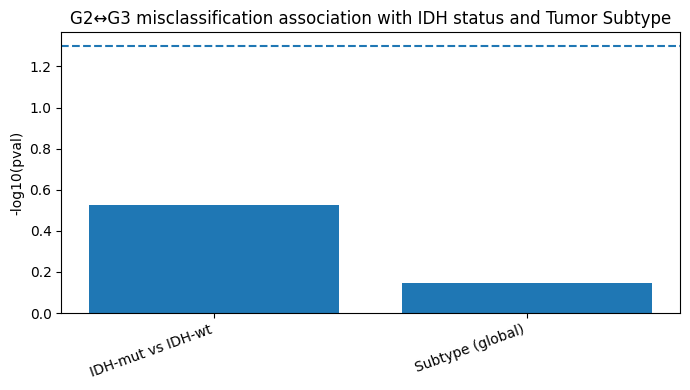

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# sanity checks 
assert "idh_out" in globals(), "Run the IDH Fisher step first to create `idh_out`."
assert "sub_stats" in globals(), "Run the subtype chi-square step first to create `sub_stats`."
assert "p_chi2" in sub_stats, "`sub_stats` must contain 'p_chi2' (global chi-square p-value)."

# Collect the two global tests
p_idh = float(idh_out.get("p_value", np.nan))
p_sub = float(sub_stats.get("p_chi2", np.nan))

tests = pd.DataFrame([
    {
        "test": "Fisher exact",
        "comparison": "IDH-mut vs IDH-wt",
        "n": int(idh_out.get("n_total", np.nan)) if pd.notna(idh_out.get("n_total", np.nan)) else np.nan,
        "effect": "odds_ratio",
        "estimate": float(idh_out.get("odds_ratio", np.nan)),
        "ci_low": float(idh_out.get("ci_low", np.nan)),
        "ci_high": float(idh_out.get("ci_high", np.nan)),
        "p_value": p_idh,
    },
    {
        "test": "Chi-square",
        "comparison": "Subtype (global)",
        "n": int(sub_stats["contingency"].values.sum()) if "contingency" in sub_stats else np.nan,
        "effect": "chi2",
        "estimate": float(sub_stats.get("chi2", np.nan)),
        "ci_low": np.nan,
        "ci_high": np.nan,
        "p_value": p_sub,
    },
])

# FDR adjust across these 2 global tests 
mask = tests["p_value"].notna()
tests["q_value_fdr"] = np.nan
if mask.sum() > 0:
    tests.loc[mask, "q_value_fdr"] = multipletests(tests.loc[mask, "p_value"], method="fdr_bh")[1]

# OR column
def fmt_or_ci(row):
    if row["effect"] != "odds_ratio" or pd.isna(row["estimate"]):
        return ""
    return f"{row['estimate']:.2f} [{row['ci_low']:.2f}, {row['ci_high']:.2f}]"

tests["OR [95% CI]"] = tests.apply(fmt_or_ci, axis=1)

report_df = tests[["test", "comparison", "n", "estimate", "OR [95% CI]", "p_value", "q_value_fdr"]]
display(report_df)

# Bar plot 
plot_col = "q_value_fdr" if report_df["q_value_fdr"].notna().any() else "p_value"

plot_df = report_df[["comparison", plot_col]].dropna().copy()
plot_df["minus_log10"] = -np.log10(plot_df[plot_col].clip(lower=1e-300))

plt.figure(figsize=(7, 4))
plt.bar(plot_df["comparison"], plot_df["minus_log10"])
plt.xticks(rotation=20, ha="right")
plt.ylabel(f"-log10(pval)")
plt.title("G2↔G3 misclassification association with IDH status and Tumor Subtype")
plt.axhline(-np.log10(0.05), linestyle="--")
plt.tight_layout()
plt.show()


Bar Plot to show error rate in Grade2/Grade3 prediction according to IDH mutation status

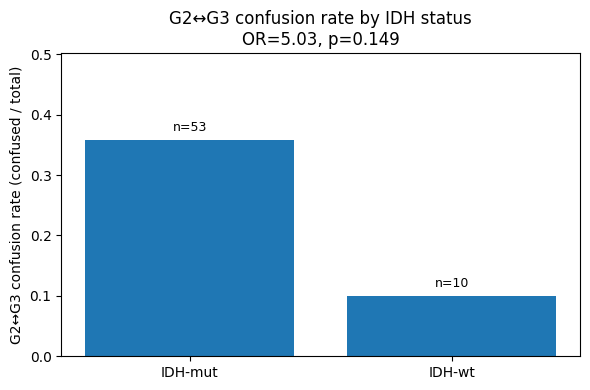

In [ ]:
# IDH contingency table 
tab = idh_ct.copy()

# standardize columns to [0,1] where 1=confused, 0=correct
if True in tab.columns or False in tab.columns:
    tab = tab.rename(columns={False: 0, True: 1})
tab = tab.reindex(columns=[0, 1], fill_value=0)

n = tab.sum(axis=1)
rate = tab[1] / n

or_ = float(idh_out["odds_ratio"])
lo  = float(idh_out["ci_low"])
hi  = float(idh_out["ci_high"])
p   = float(idh_out["p_value"])

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(rate.index.astype(str), rate.values)
ax.set_ylabel("G2↔G3 confusion rate (confused / total)")
ax.set_ylim(0, max(0.5, float(rate.max()) * 1.4))

# annotate n above bars
for i, grp in enumerate(rate.index):
    ax.text(i, rate.loc[grp] + 0.01, f"n={int(n.loc[grp])}", ha="center", va="bottom", fontsize=9)

ax.set_title(f"G2↔G3 confusion rate by IDH status\nOR={or_:.2f}, p={p:.3g}")
plt.tight_layout()
plt.show()

Bar plot to show prediction rate in Grade2/Grade3 classification according to tumor subtype

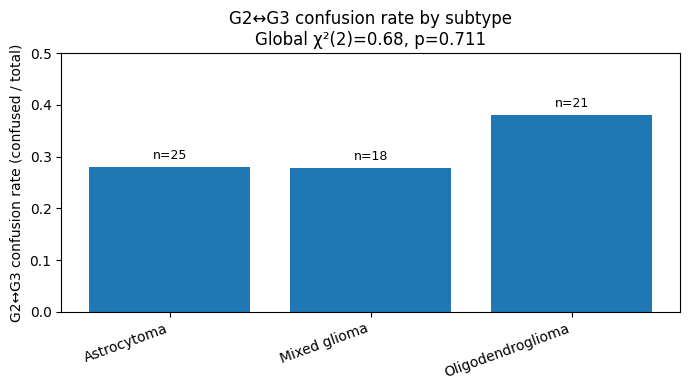

In [90]:
# expects: sub_stats dict with keys: chi2, dof, p_chi2, contingency
tab = sub_stats["contingency"].copy()   # rows=subtype, cols=0(correct),1(confused)
tab = tab.reindex(columns=[0, 1], fill_value=0)

# compute rates
n = tab.sum(axis=1)
rate = tab[1] / n

chi2 = float(sub_stats["chi2"])
dof  = int(sub_stats["dof"])
p    = float(sub_stats["p_chi2"])

fig, ax = plt.subplots(figsize=(7, 4))

ax.bar(rate.index.astype(str), rate.values)
ax.set_ylabel("G2↔G3 confusion rate (confused / total)")
ax.set_ylim(0, max(0.5, float(rate.max()) * 1.25))

# annotate n above bars
for i, (st, r) in enumerate(rate.items()):
    ax.text(i, r + 0.01, f"n={int(n.loc[st])}", ha="center", va="bottom", fontsize=9)

ax.set_title(f"G2↔G3 confusion rate by subtype\nGlobal χ²({dof})={chi2:.2f}, p={p:.3g}")
plt.xticks(rotation=20, ha="right")

plt.tight_layout()
plt.show()

We reload the Keras Tuner Hyperband run, extract completed trials and their hyperparameters and construct diagnostic plots to overview how hyperparameters relate to the validation accuracy of the model (histogram of trial validation accuracies, Spearman correlation of hyperaparameters with validation accuracy, box plots of validation accuracy grouped by number of layers, dropout, batch size and maximum width). This requires having run the core functions of the model.

In [118]:


run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536" #most recent model run folder
fold_for_tuner = 1
project_name = "grade_mlp"

objective_name = "val_accuracy"
objective_direction = "max"

tuner_dir = os.path.join(run_dir, f"fold_{fold_for_tuner:02d}", "tuner")

# Assumes already defined in session:
# - HyperbandWithBatchSize
# - build_model
# - expression_sup 
input_dim = expression_sup.shape[1]

tuner = HyperbandWithBatchSize(
    hypermodel=lambda hp: build_model(hp, input_dim=input_dim, num_classes=3),
    objective=kt.Objective(objective_name, direction=objective_direction),
    max_epochs=100,   
    factor=3,         
    directory=tuner_dir,
    project_name=project_name,
    overwrite=False
)
tuner.reload()
print("Reloaded trials:", len(tuner.oracle.trials))


# Build dataframe of trials

rows = []
for trial_id, trial in tuner.oracle.trials.items():
    if trial.score is None:
        continue
    d = dict(trial.hyperparameters.values)
    d["trial_id"] = trial_id
    d["score"] = float(trial.score)  
    d["status"] = trial.status
    rows.append(d)

df = pd.DataFrame(rows)
if df.empty:
    raise ValueError("No trials with a score found. Check tuner_dir/project_name or objective_name.")

# stable order for plots
df = df.sort_values("trial_id").reset_index(drop=True)
df["trial_num"] = np.arange(1, len(df) + 1)

# derived columns
if "lr" in df.columns:
    df["log_lr"] = np.log10(df["lr"].astype(float))
if "l2" in df.columns:
    df["log_l2"] = np.where(df["l2"].astype(float) > 0, np.log10(df["l2"].astype(float)), np.nan)

def reconstruct_units(row):
    n_layers = int(row.get("n_layers", 0) or 0)
    if n_layers <= 0:
        return []

    # pyramid_half case
    if "base_units" in row and pd.notna(row.get("base_units")):
        base = int(row["base_units"])
        min_u = int(row.get("min_units", 8))
        u = base
        units = []
        for _ in range(n_layers):
            units.append(max(u, min_u))
            u //= 2
        return units

    # free case
    units = []
    for i in range(1, n_layers + 1):
        key = f"units_l{i}"
        if key in row and pd.notna(row.get(key)):
            units.append(int(row[key]))
    return units

df["width_max"] = df.apply(lambda r: max(reconstruct_units(r), default=np.nan), axis=1)
df["width_sum"] = df.apply(lambda r: np.sum(reconstruct_units(r)) if reconstruct_units(r) else np.nan, axis=1)


# 1) Histogram: trial val_accuracy distribution

scores = df["score"].to_numpy()
best_score = scores.max()  
mean_score = scores.mean()

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(scores, bins=20)
ax.axvline(best_score, linestyle="--", linewidth=2, label=f"best = {best_score:.4f}")
ax.axvline(mean_score, linestyle=":", linewidth=2, label=f"mean = {mean_score:.4f}")
ax.set_xlabel(objective_name)
ax.set_ylabel("Count (trials)")
ax.set_title(f"Distribution of {objective_name} across trials")
ax.legend()
fig.tight_layout()

out_hist = os.path.join(run_dir, f"tuner_hist_{objective_name}.png")
fig.savefig(out_hist, dpi=200)
plt.close(fig)
print("Saved:", out_hist)


# 2) Bar plot: Spearman correlation with val_accuracy
# Positive rho => increasing HP tends to increase val_accuracy

hp_candidates = ["log_lr", "dropout", "log_l2", "n_layers", "batch_size", "base_units", "min_units", "width_max", "width_sum"]
hp_candidates = [c for c in hp_candidates if c in df.columns]

corrs = []
for c in hp_candidates:
    tmp = df[[c, "score"]].dropna()
    if len(tmp) < 3:
        continue
    rho = tmp[c].corr(tmp["score"], method="spearman")
    corrs.append((c, rho))

corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)

fig, ax = plt.subplots(figsize=(7, 4))
labels = [c for c, _ in corrs]
values = [rho for _, rho in corrs]
x = np.arange(len(labels))
ax.bar(x, values)
ax.axhline(0, linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel(f"Spearman ρ with {objective_name}")
ax.set_title(f"Hyperparameter association with {objective_name} (signed)")
fig.tight_layout()

out_corr = os.path.join(run_dir, f"tuner_corr_{objective_name}.png")
fig.savefig(out_corr, dpi=200)
plt.close(fig)
print("Saved:", out_corr)


# 3) Box plots: val_accuracy grouped by key HPs

def save_boxplot(group_col, out_name):
    tmp = df[[group_col, "score"]].dropna().copy()
    tmp[group_col] = tmp[group_col].astype(str)

    groups = []
    labels = []
    for lab, g in tmp.groupby(group_col):
        groups.append(g["score"].values)
        labels.append(lab)

    # sort labels numerically if possible
    try:
        order = np.argsort([float(x) for x in labels])
        labels = [labels[i] for i in order]
        groups = [groups[i] for i in order]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.boxplot(groups, labels=labels)
    ax.set_xlabel(group_col)
    ax.set_ylabel(objective_name)
    ax.set_title(f"{objective_name} by {group_col}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.tight_layout()

    out_path = os.path.join(run_dir, out_name)
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    print("Saved:", out_path)

if "n_layers" in df.columns:
    save_boxplot("n_layers", f"tuner_box_n_layers_{objective_name}.png")
if "dropout" in df.columns:
    save_boxplot("dropout", f"tuner_box_dropout_{objective_name}.png")
if "batch_size" in df.columns:
    save_boxplot("batch_size", f"tuner_box_batch_size_{objective_name}.png")

if df["width_max"].notna().any():
    df["width_max_cat"] = df["width_max"].round().astype("Int64").astype(str)
    save_boxplot("width_max_cat", f"tuner_box_width_max_{objective_name}.png")


Reloading Tuner from C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\fold_01\tuner\grade_mlp\tuner0.json
Reloaded trials: 254


c:\Users\joann\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_hist_val_accuracy.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_corr_val_accuracy.png


C:\Users\joann\AppData\Local\Temp\ipykernel_53412\1646129885.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)


Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_box_n_layers_val_accuracy.png


C:\Users\joann\AppData\Local\Temp\ipykernel_53412\1646129885.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)
C:\Users\joann\AppData\Local\Temp\ipykernel_53412\1646129885.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)


Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_box_dropout_val_accuracy.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_box_batch_size_val_accuracy.png


C:\Users\joann\AppData\Local\Temp\ipykernel_53412\1646129885.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)


Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\tuner_box_width_max_val_accuracy.png


Permutation Importance Graphs 

In [ ]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536" #most recent model run folder
final_dir = os.path.join(run_dir, "final")

genes_path = r"C:/Users/joann/Desktop/M2/Deep_Learning/merged_genes.csv"  
# -----------------------

# Load saved permutation importance tables produced above
global_csv = os.path.join(final_dir, "perm_importance_global.csv")
perclass_csv = os.path.join(final_dir, "perm_importance_per_class.csv")

df_global = pd.read_csv(global_csv)
df_per = pd.read_csv(perclass_csv)

# Load gene mapping table
genes = pd.read_csv(genes_path)

#map ensembl IDs to gene names
possible_ensembl_cols = ["ensembl", "ensembl_id", "ensembl_gene_id", "gene_id", "GeneID", "Ensembl_ID"]
ensembl_col = None
for c in possible_ensembl_cols:
    if c in genes.columns:
        ensembl_col = c
        break

# If not found, pick the first column that looks like Ensembl IDs
if ensembl_col is None:
    for c in genes.columns:
        if genes[c].astype(str).str.startswith("ENSG").any():
            ensembl_col = c
            break

if ensembl_col is None:
    raise ValueError(
        "Couldn't detect the Ensembl ID column in merged_genes.csv. "
        "Please check the column names and set ensembl_col manually."
    )

if "gene_name" not in genes.columns:
    raise ValueError("merged_genes.csv must contain a 'gene_name' column.")

# strip Ensembl version suffix: ENSG00000.12 -> ENSG00000
def strip_version(s: str) -> str:
    s = str(s)
    return s.split(".")[0]

genes["_ensembl_base"] = genes[ensembl_col].map(strip_version)
ens_to_name = (
    genes.dropna(subset=["_ensembl_base", "gene_name"])
         .drop_duplicates(subset=["_ensembl_base"])
         .set_index("_ensembl_base")["gene_name"]
         .to_dict()
)

def map_feature_label(ensembl_id: str) -> str:
    base = strip_version(ensembl_id)
    name = ens_to_name.get(base, None)
    if name is None or str(name).strip() == "" or str(name).lower() == "nan":
        return base  # fallback to ensembl if no mapping
    return str(name)

# Add gene_name column
df_global["ensembl"] = df_global["feature"].map(strip_version)
df_global["gene_name"] = df_global["feature"].map(map_feature_label)

df_per["ensembl"] = df_per["feature"].map(strip_version)
df_per["gene_name"] = df_per["feature"].map(map_feature_label)

# Avoid duplicate labels: if gene_name repeats, append (ENSG...)
def make_unique_labels(df):
    counts = df["gene_name"].value_counts()
    dup = set(counts[counts > 1].index)
    labels = []
    for gn, ens in zip(df["gene_name"], df["ensembl"]):
        if gn in dup:
            labels.append(f"{gn} ({ens})")
        else:
            labels.append(gn)
    return labels

df_global["label"] = make_unique_labels(df_global)
df_per["label"] = make_unique_labels(df_per)

# Save renamed tables
df_global.to_csv(os.path.join(final_dir, "perm_importance_global_gene_names.csv"), index=False)
df_per.to_csv(os.path.join(final_dir, "perm_importance_per_class_gene_names.csv"), index=False)


#Plots
def bar_topk(df, score_col, std_col, title, filename, top_k=10):
    d = df.sort_values(score_col, ascending=False).head(top_k).copy()
    d = d.iloc[::-1]  # barh: biggest at top

    fig, ax = plt.subplots(figsize=(8, 0.4*len(d) + 2.5))
    ax.barh(d["label"].astype(str), d[score_col].to_numpy(), xerr=d[std_col].to_numpy())
    ax.set_xlabel("Performance drop after permutation")
    ax.set_title(title)
    fig.tight_layout()
    out_path = os.path.join(final_dir, filename)
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    print("Saved:", out_path)

top_k = 10
class_names = ["G2", "G3", "G4"]

# Global plots
bar_topk(
    df_global, "drop_accuracy_mean", "drop_accuracy_std",
    title=f"Permutation importance (Global Accuracy) — Top {top_k}",
    filename=f"perm_top{top_k}_global_accuracy_gene_names.png",
    top_k=top_k
)
bar_topk(
    df_global, "drop_macro_f1_mean", "drop_macro_f1_std",
    title=f"Permutation importance (Global Macro-F1) — Top {top_k}",
    filename=f"perm_top{top_k}_global_macro_f1_gene_names.png",
    top_k=top_k
)

# Per-class plots
for cname in class_names:
    bar_topk(
        df_per,
        f"drop_f1_{cname}_mean", f"drop_f1_{cname}_std",
        title=f"Permutation importance (Per-class F1: {cname}) — Top {top_k}",
        filename=f"perm_top{top_k}_f1_{cname}_gene_names.png",
        top_k=top_k
    )
    bar_topk(
        df_per,
        f"drop_recall_{cname}_mean", f"drop_recall_{cname}_std",
        title=f"Permutation importance (Per-class Recall: {cname}) — Top {top_k}",
        filename=f"perm_top{top_k}_recall_{cname}_gene_names.png",
        top_k=top_k
    )



Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_global_accuracy_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_global_macro_f1_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_f1_G2_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_recall_G2_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_f1_G3_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_recall_G3_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_f1_G4_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\perm_top10_recall_G4_gene_names.png


Integrated Gradient Importance to identify important genes for each grade prediction

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


def _ig_batch(model, x, y, baseline, steps=32):
    """
    Integrated Gradients for a batch.
    x, baseline: (B, F) float32
    y: (B,) int labels
    returns: (B, F) IG attributions 
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.int32)

    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas = tf.reshape(alphas, (steps + 1, 1, 1))

    x_exp = tf.expand_dims(x, axis=0)
    b_exp = tf.expand_dims(baseline, axis=0)
    x_interp = b_exp + alphas * (x_exp - b_exp)

    S = steps + 1
    B = tf.shape(x)[0]
    F = tf.shape(x)[1]

    x_flat = tf.reshape(x_interp, (S * B, F))
    y_rep = tf.repeat(y, repeats=S)

    with tf.GradientTape() as tape:
        tape.watch(x_flat)
        preds = model(x_flat, training=False)
        idx = tf.stack([tf.range(tf.shape(y_rep)[0]), y_rep], axis=1)
        target = tf.gather_nd(preds, idx)

    grads = tape.gradient(target, x_flat)
    grads = tf.reshape(grads, (S, B, F))

    grads_avg = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads_avg, axis=0)

    ig = (x - baseline) * avg_grads
    return ig.numpy()


def integrated_gradients_importance_multiclass(
    model,
    X_s: np.ndarray,
    y: np.ndarray,
    feature_names,
    out_dir: str,
    class_names=("G2", "G3", "G4"),
    steps: int = 32,
    batch_size: int = 128,
    top_k: int = 10,
    max_features: int | None = 200,  # only for reporting/plots, not for model input
    baseline_mode: str = "zeros",
    seed: int = 42,
):
    """
    computes only absolute IG summaries
    """
    os.makedirs(out_dir, exist_ok=True)

    np.random.seed(seed)
    tf.random.set_seed(seed)

    X_s = np.asarray(X_s, dtype=np.float32)
    y = np.asarray(y).astype(int)

    n_samples, n_features = X_s.shape
    feature_names = np.array(list(feature_names), dtype=object)
    if feature_names.shape[0] != n_features:
        raise ValueError("feature_names length does not match X_s number of columns.")

    # baseline 
    if baseline_mode == "zeros":
        baseline = np.zeros_like(X_s, dtype=np.float32)
    elif baseline_mode == "mean":
        baseline = np.tile(X_s.mean(axis=0, keepdims=True), (n_samples, 1)).astype(np.float32)
    else:
        raise ValueError("baseline_mode must be 'zeros' or 'mean'")

    # compute IG on full feature set 
    abs_ig_all_full = np.zeros_like(X_s, dtype=np.float32)  # (N, F)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        xb = X_s[start:end]
        yb = y[start:end]
        bb = baseline[start:end]

        ig_b = _ig_batch(model, xb, yb, bb, steps=steps)  # (B, F) signed
        abs_ig_all_full[start:end] = np.abs(ig_b).astype(np.float32)

    # choose features to REPORT (optional) 
    if (max_features is not None) and (n_features > max_features):
        variances = X_s.var(axis=0)
        feat_idx = np.argsort(-variances)[:max_features]
        feat_idx = np.sort(feat_idx)
        note = f"NOTE: IG computed on ALL {n_features} features, but reporting top-{max_features} variance genes."
    else:
        feat_idx = np.arange(n_features)
        note = f"NOTE: IG computed and reported on all {n_features} features."

    with open(os.path.join(out_dir, "grad_importance_NOTE.txt"), "w") as f:
        f.write(note + "\n")
    print(note)

    names_sel = feature_names[feat_idx]
    abs_ig_sel = abs_ig_all_full[:, feat_idx]

    # GLOBAL summary 
    df_global = pd.DataFrame({
        "feature": names_sel,
        "mean_abs_ig": abs_ig_sel.mean(axis=0),
        "std_abs_ig":  abs_ig_sel.std(axis=0),
    }).sort_values("mean_abs_ig", ascending=False)

    df_global.to_csv(os.path.join(out_dir, "grad_importance_global_unsigned.csv"), index=False)

    # PER-CLASS summary 
    per_class_dfs = []
    for c, cname in enumerate(class_names):
        mask = (y == c)
        if mask.sum() == 0:
            tmp = pd.DataFrame({
                "feature": names_sel,
                f"mean_abs_ig_{cname}": np.nan,
                f"std_abs_ig_{cname}":  np.nan,
            })
        else:
            tmp = pd.DataFrame({
                "feature": names_sel,
                f"mean_abs_ig_{cname}": abs_ig_sel[mask].mean(axis=0),
                f"std_abs_ig_{cname}":  abs_ig_sel[mask].std(axis=0),
            })
        per_class_dfs.append(tmp)

    df_per_class = per_class_dfs[0]
    for k in per_class_dfs[1:]:
        df_per_class = df_per_class.merge(k, on="feature")

    df_per_class.to_csv(os.path.join(out_dir, "grad_importance_unsigned_per_class.csv"), index=False)

    # plotting 
    def _bar_topk(df, score_col, title, filename, top_k=10):
        d = df.sort_values(score_col, ascending=False).head(top_k).copy()
        d = d.iloc[::-1]
        fig, ax = plt.subplots(figsize=(8, 0.4 * len(d) + 2.5))
        ax.barh(d["feature"].astype(str), d[score_col].to_numpy())
        ax.set_xlabel("Mean |Integrated Gradient|")
        ax.set_title(title)
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, filename), dpi=200)
        plt.close(fig)

    _bar_topk(
        df_global,
        score_col="mean_abs_ig",
        title=f"Gradient importance (Global) — Top {top_k}",
        filename=f"grad_top{top_k}_global.png",
        top_k=top_k
    )

    for cname in class_names:
        _bar_topk(
            df_per_class,
            score_col=f"mean_abs_ig_{cname}",
            title=f"Gradient importance (Class {cname}) — Top {top_k}",
            filename=f"grad_top{top_k}_{cname}.png",
            top_k=top_k
        )

    baseline_summary = {
        "note": note,
        "method": "integrated_gradients",
        "steps": int(steps),
        "baseline_mode": baseline_mode,
        "evaluated_features": int(len(feat_idx)),
        "batch_size": int(batch_size),
        "model_input_features": int(n_features),
    }
    with open(os.path.join(out_dir, "grad_importance_baseline.json"), "w") as f:
        json.dump(baseline_summary, f, indent=2)

    print("Saved gradient importance CSVs + plots to:", out_dir)
    return df_global, df_per_class, baseline_summary


Run Gradient Importance Analysis. To do this we load the model saved locally

In [ ]:


run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536" #most recent model run folder
final_dir = os.path.join(run_dir, "final")
out_dir = os.path.join(final_dir, "grad_importance")

# 1) load model
model = load_model(os.path.join(final_dir, "best_model.keras"))

# 2) load scaler
scaler = joblib.load(os.path.join(final_dir, "scaler.joblib"))

# 3) rebuild X_test and y_test 
test_ids = pd.read_csv(os.path.join(run_dir, "test_ids.csv")).iloc[:,0].astype(str).tolist()
test_ids = [i for i in test_ids if i in expression_sup.index]

label_map = {"G2":0, "G3":1, "G4":2}
X_test = expression_sup.loc[test_ids]
y_test = samples_sup.loc[X_test.index, "tumor_grade"].map(label_map).astype(int).to_numpy()

X_test_s = scaler.transform(X_test).astype(np.float32)

# 4) run IG with all features reported
df_g, df_pc, meta = integrated_gradients_importance_multiclass(
    model=model,
    X_s=X_test_s,
    y=y_test,
    feature_names=X_test.columns,
    out_dir=out_dir,
    class_names=("G2","G3","G4"),
    steps=32,
    batch_size=128,
    top_k=10,
    max_features=None,     
    baseline_mode="zeros",
)


NOTE: IG computed and reported on ALL 2000 features.
Saved gradient importance CSVs + plots to: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final\grad_importance


We Map ensembl IDs to Gene Names in the Gradient Importance summaries and graphs

In [ ]:
import os
import numpy as np
import pandas as pd


run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536" #most recent model run folder
final_dir = os.path.join(run_dir, "final/grad_importance")

genes_path = r"C:/Users/joann/Desktop/M2/Deep_Learning/merged_genes.csv"  

# gradient IG outputs (from IG functions above, saved locally)
global_csv = os.path.join(final_dir, "grad_importance_global_unsigned.csv")
perclass_csv = os.path.join(final_dir, "grad_importance_unsigned_per_class.csv")


df_global = pd.read_csv(global_csv)
df_per = pd.read_csv(perclass_csv)

# Load gene mapping table
genes = pd.read_csv(genes_path)

#gene mapping
possible_ensembl_cols = ["ensembl", "ensembl_id", "ensembl_gene_id", "gene_id", "GeneID", "Ensembl_ID"]
ensembl_col = None
for c in possible_ensembl_cols:
    if c in genes.columns:
        ensembl_col = c
        break

# If not found, pick the first column that looks like Ensembl IDs
if ensembl_col is None:
    for c in genes.columns:
        if genes[c].astype(str).str.startswith("ENSG").any():
            ensembl_col = c
            break

if ensembl_col is None:
    raise ValueError(
        "Couldn't detect the Ensembl ID column in merged_genes.csv. "
        "Please check the column names and set ensembl_col manually."
    )

if "gene_name" not in genes.columns:
    raise ValueError("merged_genes.csv must contain a 'gene_name' column.")

# strip Ensembl version suffix: ENSG00000.12 -> ENSG00000
def strip_version(s: str) -> str:
    s = str(s)
    return s.split(".")[0]

genes["_ensembl_base"] = genes[ensembl_col].map(strip_version)
ens_to_name = (
    genes.dropna(subset=["_ensembl_base", "gene_name"])
         .drop_duplicates(subset=["_ensembl_base"])
         .set_index("_ensembl_base")["gene_name"]
         .to_dict()
)

def map_feature_label(ensembl_id: str) -> str:
    base = strip_version(ensembl_id)
    name = ens_to_name.get(base, None)
    if name is None or str(name).strip() == "" or str(name).lower() == "nan":
        return base  # fallback to ensembl if no mapping
    return str(name)

# Add gene_name column
df_global["ensembl"] = df_global["feature"].map(strip_version)
df_global["gene_name"] = df_global["feature"].map(map_feature_label)

df_per["ensembl"] = df_per["feature"].map(strip_version)
df_per["gene_name"] = df_per["feature"].map(map_feature_label)

# Avoid duplicate labels: if gene_name repeats, append (ENSG...)
def make_unique_labels(df):
    counts = df["gene_name"].value_counts()
    dup = set(counts[counts > 1].index)
    labels = []
    for gn, ens in zip(df["gene_name"], df["ensembl"]):
        if gn in dup:
            labels.append(f"{gn} ({ens})")
        else:
            labels.append(gn)
    return labels

df_global["label"] = make_unique_labels(df_global)
df_per["label"] = make_unique_labels(df_per)

# Save renamed tables
df_global.to_csv(os.path.join(final_dir, "grad_importance_global_gene_names.csv"), index=False)
df_per.to_csv(os.path.join(final_dir, "grad_importance_per_class_gene_names.csv"), index=False)

print("Saved:")
print(" -", os.path.join(final_dir, "grad_importance_global_gene_names.csv"))
print(" -", os.path.join(final_dir, "grad_importance_per_class_gene_names.csv"))


Saved:
 - C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_importance_global_gene_names.csv
 - C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_importance_per_class_gene_names.csv


Repeat the above for the plots presenting the top 10 most important genes per grade

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


run_dir = r"C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536"
final_dir = os.path.join(run_dir, "final/grad_importance")

genes_path = r"C:/Users/joann/Desktop/M2/Deep_Learning/merged_genes.csv"  

# gradient IG outputs
global_csv = os.path.join(final_dir, "grad_importance_global_unsigned.csv")
perclass_csv = os.path.join(final_dir, "grad_importance_unsigned_per_class.csv")
# -----------------------

# Load IG tables
df_global = pd.read_csv(global_csv)
df_per = pd.read_csv(perclass_csv)

# Load gene mapping table
genes = pd.read_csv(genes_path)

# gene mapping
possible_ensembl_cols = ["ensembl", "ensembl_id", "ensembl_gene_id", "gene_id", "GeneID", "Ensembl_ID"]
ensembl_col = None
for c in possible_ensembl_cols:
    if c in genes.columns:
        ensembl_col = c
        break

if ensembl_col is None:
    for c in genes.columns:
        if genes[c].astype(str).str.startswith("ENSG").any():
            ensembl_col = c
            break

if ensembl_col is None:
    raise ValueError(
        "Couldn't detect the Ensembl ID column in merged_genes.csv. "
        "Please check the column names and set ensembl_col manually."
    )

if "gene_name" not in genes.columns:
    raise ValueError("merged_genes.csv must contain a 'gene_name' column.")

def strip_version(s: str) -> str:
    s = str(s)
    return s.split(".")[0]

genes["_ensembl_base"] = genes[ensembl_col].map(strip_version)
ens_to_name = (
    genes.dropna(subset=["_ensembl_base", "gene_name"])
         .drop_duplicates(subset=["_ensembl_base"])
         .set_index("_ensembl_base")["gene_name"]
         .to_dict()
)

def map_feature_label(ensembl_id: str) -> str:
    base = strip_version(ensembl_id)
    name = ens_to_name.get(base, None)
    if name is None or str(name).strip() == "" or str(name).lower() == "nan":
        return base
    return str(name)

# Add gene_name + label columns
df_global["ensembl"] = df_global["feature"].map(strip_version)
df_global["gene_name"] = df_global["feature"].map(map_feature_label)

df_per["ensembl"] = df_per["feature"].map(strip_version)
df_per["gene_name"] = df_per["feature"].map(map_feature_label)

def make_unique_labels(df):
    counts = df["gene_name"].value_counts()
    dup = set(counts[counts > 1].index)
    labels = []
    for gn, ens in zip(df["gene_name"], df["ensembl"]):
        if gn in dup:
            labels.append(f"{gn} ({ens})")
        else:
            labels.append(gn)
    return labels

df_global["label"] = make_unique_labels(df_global)
df_per["label"] = make_unique_labels(df_per)

# Save renamed tables
df_global.to_csv(os.path.join(final_dir, "grad_importance_global_gene_names.csv"), index=False)
df_per.to_csv(os.path.join(final_dir, "grad_importance_per_class_gene_names.csv"), index=False)

#Plotting
def bar_topk_noerr(df, score_col, title, filename, top_k=10, xlabel="Mean |Integrated Gradient|"):
    d = df.sort_values(score_col, ascending=False).head(top_k).copy()
    d = d.iloc[::-1]  # barh: biggest at top

    fig, ax = plt.subplots(figsize=(8, 0.4*len(d) + 2.5))
    ax.barh(d["label"].astype(str), d[score_col].to_numpy())  # <-- no xerr
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    fig.tight_layout()
    out_path = os.path.join(final_dir, filename)
    fig.savefig(out_path, dpi=200)
    plt.close(fig)
    print("Saved:", out_path)

top_k = 10
class_names = ["G2", "G3", "G4"]

# Global importance plot

bar_topk_noerr(
    df_global, "mean_abs_ig",
    title=f"Gradient importance (Global) — Top {top_k}",
    filename=f"grad_top{top_k}_global_gene_names.png",
    top_k=top_k,
    xlabel="Mean |Integrated Gradient|"
)

# Per class plots
for cname in class_names:
    score_col = f"mean_abs_ig_{cname}"
    if score_col not in df_per.columns:
        print(f"Skipping {cname}: column not found -> {score_col}")
        continue

    bar_topk_noerr(
        df_per, score_col,
        title=f"Gradient importance (Class {cname}) — Top {top_k}",
        filename=f"grad_top{top_k}_{cname}_gene_names.png",
        top_k=top_k,
        xlabel="Mean |Integrated Gradient|"
    )


Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_top10_global_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_top10_G2_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_top10_G3_gene_names.png
Saved: C:/Users/joann/Desktop/M2/Deep_Learning/MLP_run/20260105_181536\final/grad_importance\grad_top10_G4_gene_names.png
